Setup

In [1]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'

########################

## Setting paths in python
#import sys
#sys.path.insert(0, analyticsDir)

# Imports
#from data_mining import fetch_tickers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant




# US Stock Market Trends and Rare Events
In this project we assess some general market trends.
It is our contention that, 
overall and in the long-term, 
the US stock market increases in value at a rate significantly higher than inflation 
and typically higher than most other investment opportunities. 
This is why Condor suggests a diversified, 
mid- to long-hold investment strategy.
However, there are clearly periods in-which 
the market deviates from this course.
This can lead to sharp return increases and losses.
Some can extend over multiple years.
These periods cause anxiety in investors 
and can lead to counter-productive portfolio management decisions;
such as, selling stocks as overall market prices trend downwards.

To overcome concerns, we hope to quantify conditions around market deviations.
We believe that investors can act more confidently during unusual deviation events 
if we can inform and prepare them for such inevitabilities prior to investment.
To do this, we will 
(1) use the S&P 500 as a metric for 'overall' market conditions, 
(2) identify a simple trend for post-depression market returns,
(3) identify statistically significant deviations from returns, and
(4) quantify the distribution of how long such events last.
In addition, this analysis will give us an opportunity to assess
statistical parameters and strategies needed for portfolio optimization and managment.
In particular, 
we will take a first pass at defining an appropriate sampling frequency and period,
and we will apply robust statistical metrics of scale for estimating returns and volatility.

## I. Load S&P 500 data 
We are using the S&P 500 as a metric for overall US stock market value.
The data was collected prior to analysis by PJ using polygon.io API.


In [2]:
sp500_history = pd.read_csv(dataDir+'/sp500_GSPC_50y.tab', sep='\t')

# Convert date column to datetime
sp500_history['Date'] = pd.to_datetime(sp500_history['Date'])

# Preference to see data start to end so flip it
sp500_history.sort_values('Date', axis=0, ascending=True, inplace=True)

#take a look
sp500_history.info()
sp500_history


<class 'pandas.core.frame.DataFrame'>
Index: 12608 entries, 12607 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         12608 non-null  datetime64[ns]
 1   Open         12608 non-null  float64       
 2   High         12608 non-null  float64       
 3   Low          12608 non-null  float64       
 4   Close*       12608 non-null  float64       
 5   Adj Close**  12608 non-null  float64       
 6   Volume       12608 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 788.0 KB


,Date,Open,High,Low,Close*,Adj Close**,Volume
12607,1974-07-18,0.00,85.39,83.13,83.78,83.78,13980000
12606,1974-07-19,0.00,84.67,82.87,83.54,83.54,11080000
12605,1974-07-22,0.00,84.44,82.59,83.81,83.81,9290000
12604,1974-07-23,0.00,85.63,83.67,84.65,84.65,12910000
12603,1974-07-24,0.00,85.64,83.61,84.99,84.99,12870000
...,...,...,...,...,...,...,...
4,2024-07-11,5635.21,5642.45,5576.53,5584.54,5584.54,4020950000
3,2024-07-12,5590.76,5655.56,5590.44,5615.35,5615.35,3700280000
2,2024-07-15,5638.16,5666.94,5614.75,5631.22,5631.22,3620470000
1,2024-07-16,5644.09,5669.67,5639.02,5667.20,5667.20,4041760000


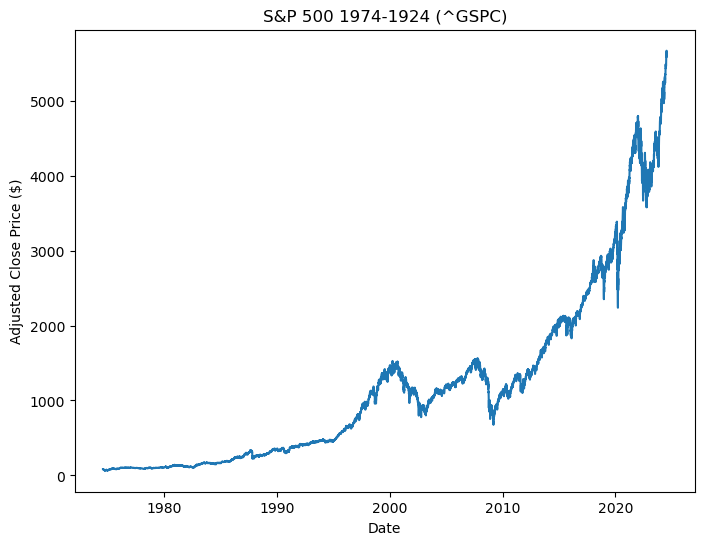

In [3]:
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(sp500_history['Date'], sp500_history['Adj Close**'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.title('S&P 500 1974-1924 (^GSPC)')
plt.show()

## II. Identify Trend 
Here we want to identify the overall market trend in the form
of a simple, closed-form analytical equation. 
We will consider line, quadratic, cubic, exponential and logrithmic functions.
We will then assess each based on fit and complexity using an information criterion.
Here we will use the corrected Akaike Information Criterion, AICc.

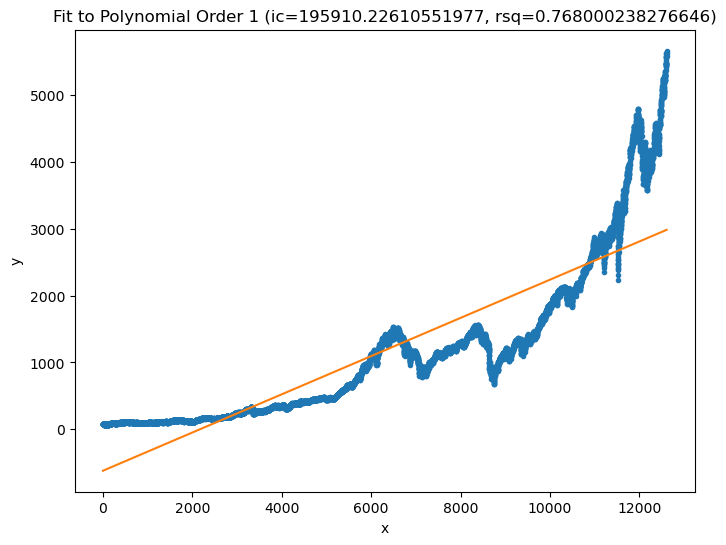

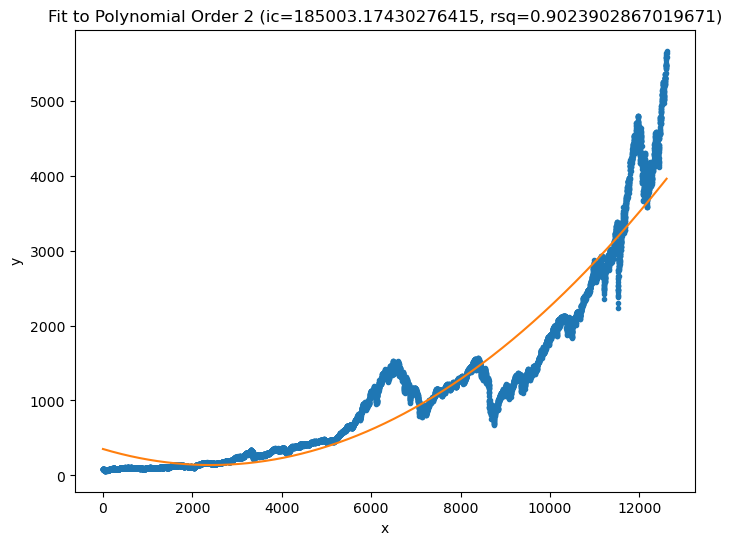

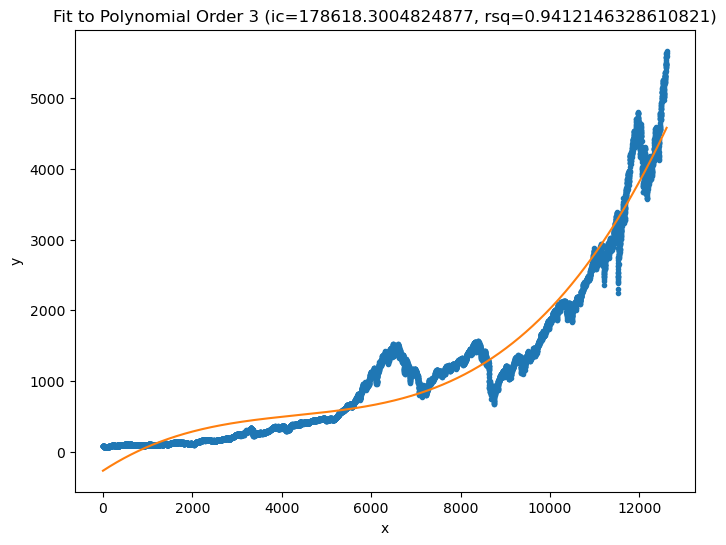

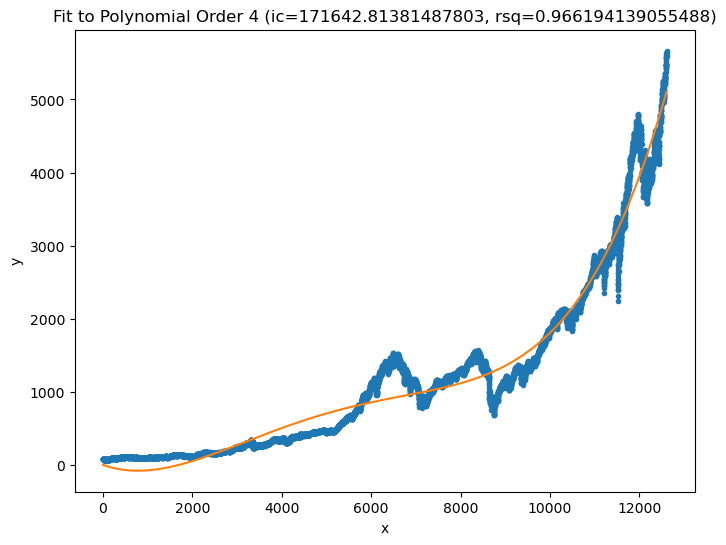

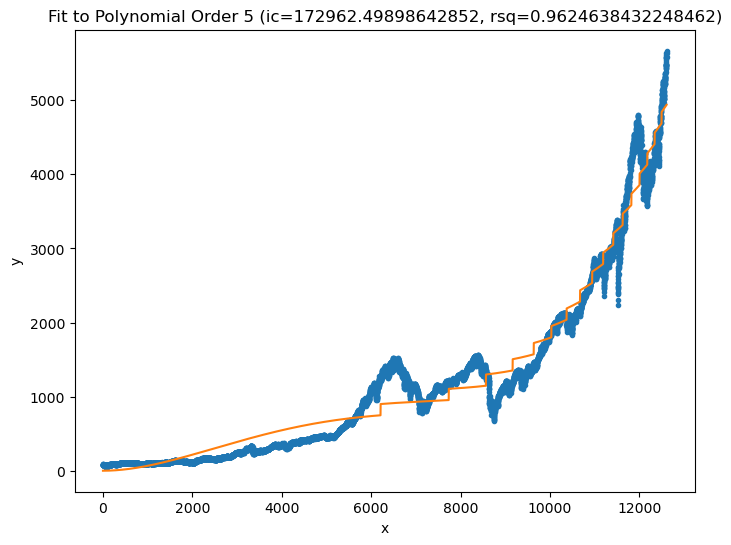

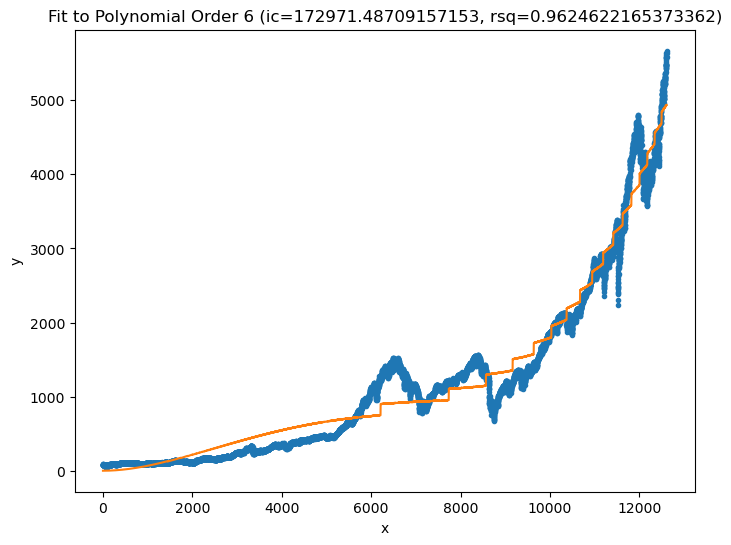

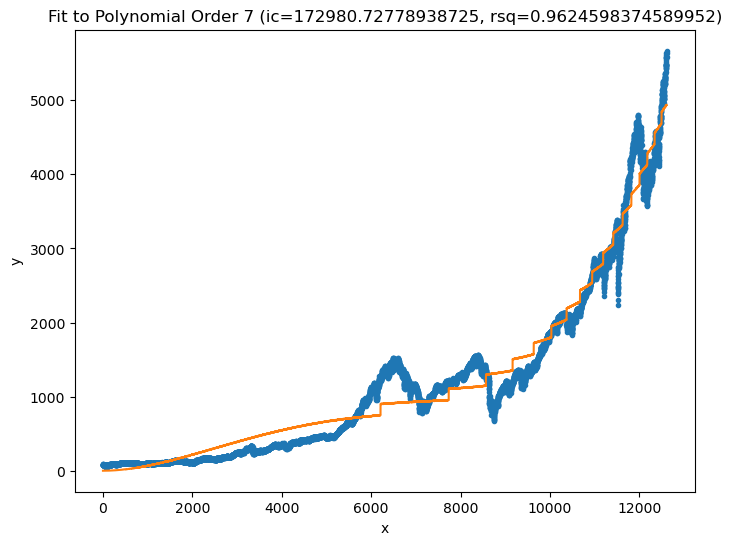

[[1.         1.00015863]
 [1.         1.00031728]
 [1.         1.00047596]
 ...
 [1.         7.38554085]
 [1.         7.38671241]
 [1.         7.38788416]]


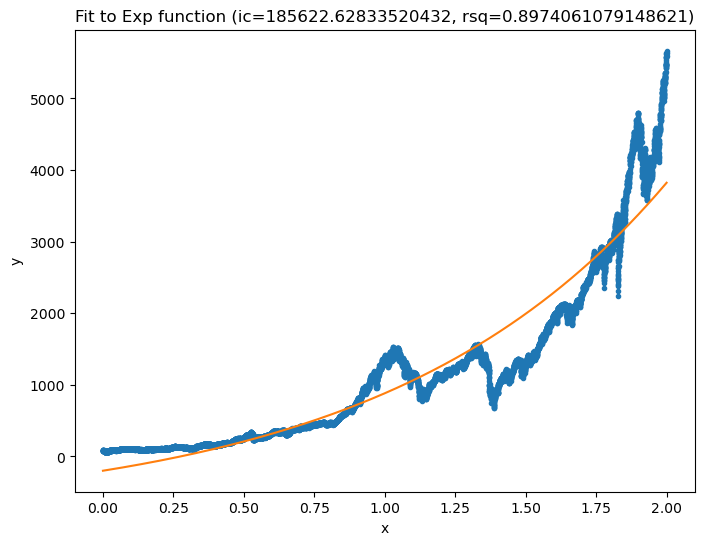

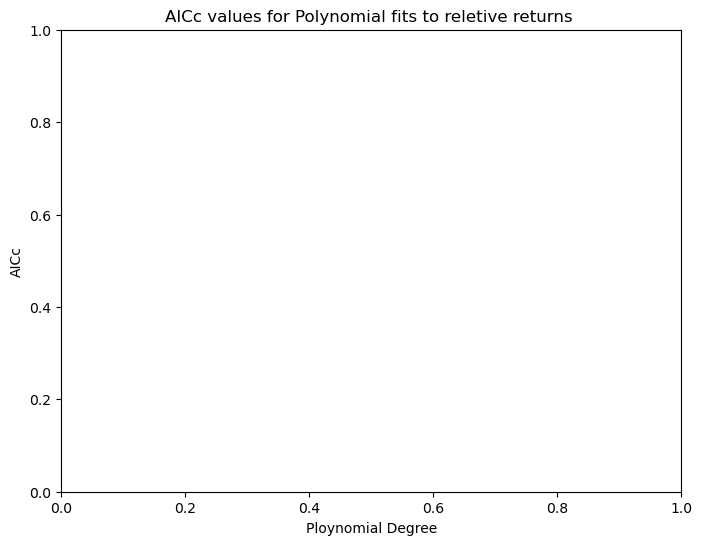

[195910.22610551977, 185003.17430276415, 178618.3004824877, 171642.81381487803, 172962.49898642852, 172971.48709157153, 172980.72778938725, 185622.62833520432]


In [15]:

# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 7

##############

names = []
minIc = 1000
minIcIndex = -1
ics = []
rsqs = []

x = np.arange(len(sp500_history['Adj Close**']))
y = sp500_history['Adj Close**']



def run_model(X,y,name,x):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X).fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    plt.plot(x, y,'.',x,yHat,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
    plt.show()
    
    return ic, rsq, regr

# Run through all poly deg models
for i in range(maxPolyOrder):
    polyOrder = i+1
    name = 'Polynomial Order '+str(polyOrder)

    # Create X matrix
    if polyOrder == 1:
        X = add_constant(x.reshape(-1, 1))
    else:
        X = np.c_[X, x**polyOrder]

    ic, rsq, regr = run_model(X,y,name,x)
    names.append(name)
    ics.append(ic)
    rsqs.append(rsq)


# Run for exp function
x = x+1
x = x/np.mean(x)
X = add_constant(np.exp(x.reshape(-1, 1)))
print(X)
ic, rsq, regr = run_model(X,y,'Exp function',x)
ics.append(ic)
rsqs.append(rsq)

# Plot AICcs for inspection
plt.figure(figsize=(8, 6))
#plt.plot(np.arange(30)+1, ics,'.')
plt.xlabel('Ploynomial Degree')
plt.ylabel('AICc')
plt.title('AICc values for Polynomial fits to reletive returns ')
plt.show()

print(ics)
    

## ???. Transform to Returns
Our statistical analysis will be based on monthly returns.
To simplify this we are considering 30 day periods from time t to t+30 days. 
As a matter of practice, we are considering relative returns.

[-0.10993077 -0.10282499 -0.12289703 ...  0.04760647  0.04541019
  0.02843898]
['1974-08-19T00:00:00.000000000' '1974-08-20T00:00:00.000000000'
 '1974-08-21T00:00:00.000000000' ... '2024-07-15T00:00:00.000000000'
 '2024-07-16T00:00:00.000000000' '2024-07-17T00:00:00.000000000']


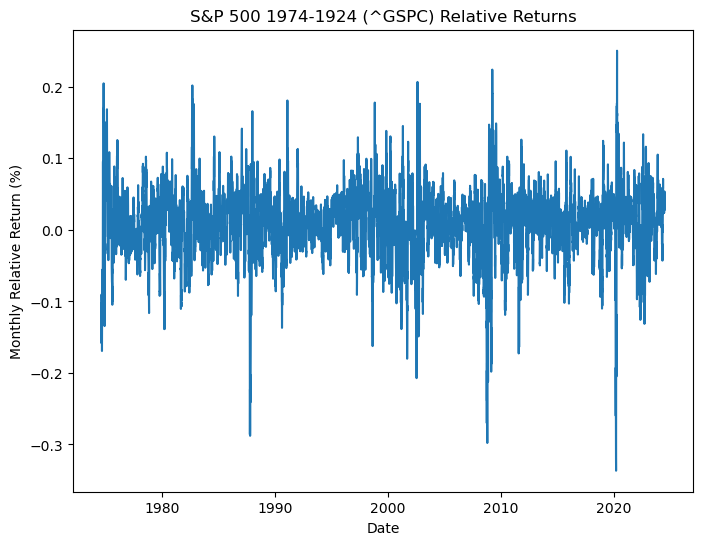

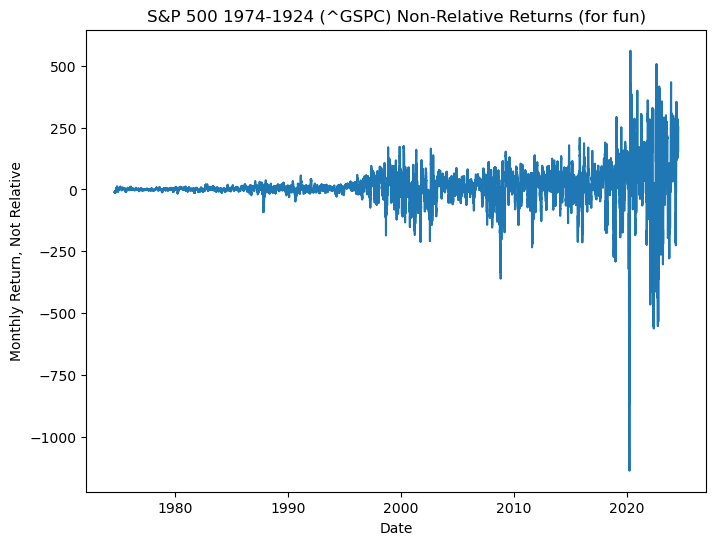

In [37]:
# Open market days in a month (4.25 weeks in 30 days * 2 weekends)
days = 30 - 8
n = len(y_price)-days

# calculate returns
y_return = np.zeros(n)
y_return_nonrel = np.zeros(n) #just for a fun note
x_date_return = []
for i in range(n):
    y_return[i] = (y_price[i+days] - y_price[i]) / y_price[i]
    y_return_nonrel[i] = (y_price[i+days] - y_price[i])
    x_date_return.append(x_date[i+days])

x_date_return = np.array(x_date_return)

# Show for sanity check
print(y_return)
print(x_date_return)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_date_return, y_return)
plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('S&P 500 1974-1924 (^GSPC) Relative Returns')
plt.show()

# Plot the non relative data for fun
plt.figure(figsize=(8, 6))
plt.plot(x_date_return, y_return_nonrel)
plt.xlabel('Date')
plt.ylabel('Monthly Return, Not Relative')
plt.title('S&P 500 1974-1924 (^GSPC) Non-Relative Returns (for fun)')
plt.show()

## IV. Determine sampling frequency
For any statistical analysis we have to determine how much time will pass
between t_i and t_(i+1) in our data set.
It may seem like 30 days is an appropriate number since it is how we defined returns;
however, we will consider a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing there dependence
since a proper statistical analysis would require statistically independent samples.
To do this we consider the return is based on both a 'drift' and 'noise' term.
The drift is defined by the trend (Section III).
By subtracting the expected value based on this trend, 
we are left with the noise term.
To ensure the noise term is statistically independent, 
we will select a sampling rate such that each point in our time series 
is independent with a 95% confidence.
Ultimately this is done by considering the elapsed time for the 
auto-correlation function to drop to a 95% confidence level of zero.
Note, this assumes all dependence is related to time, 
which is supported by the results.

### i. Remove Drift

### ii. Calculate Auto-Correlation 

### iii. Determine Sampling Rate and Final Time Series

## V. Identify Deviations
Using median and absolute deviation as a robust analogue to 
the sample mean and standard deviation,
which are commonly used for expected return and volatility metrics. 
Here we are defining 1, 2 and 3 abs devs as abnormal, semi-rare and rare events.

## VI. Event and Lengths
Here we are concerned with events that are semi-rare or less frequent.
When an event is identified as prob <= semi-rare, 
we consider the proceeding time points until one reaches prob > semi-rare.
This determines the overall events length.

### i. Determine Deviation Events and Lengths

### ii. Find cumulative Event Length Distribution

## Application for Managment  
Can we use the sampling rate here for portfolio analysis in general?
Does Event Length (EL) help us determine a sampling period for portfolio analysis in general?
Does EL help us determine a hold or portfolio re-balancing strategy?